In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

from support import compute_loss_accuracy, accuracy_number, Flattener, CNN

# Загружаем тестовые данные

In [2]:
data_test = dset.SVHN('./data/', split='test', download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ]))

Using downloaded and verified file: ./data/test_32x32.mat


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA")
else:
    device = torch.device('cpu')
    print("CPU")

CPU


Загружаем натренированную модель

In [4]:
load_model = torch.load("./model_svhn_bo1.pth", device)
load_model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Flattener()
    (12): Linear(in_features=1600, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Linear(in_features=128, out_features=10, bia

### Тестируем!

In [6]:
batch_size = 64
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_loss, test_accuracy = compute_loss_accuracy(load_model, test_loader, loss, device)
print("Test loss: %f, accuracy: %f" % (test_loss, test_accuracy))

Test loss: 0.231083, accuracy: 0.934465


Точность для каждой цифры

In [7]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
for i in range(10):
  accuracy = accuracy_number(load_model, test_loader, i, device)
  print("Number: %i, accuracy: %f" % (i, accuracy))

Number: 0, accuracy: 0.938647
Number: 1, accuracy: 0.964111
Number: 2, accuracy: 0.952760
Number: 3, accuracy: 0.906662
Number: 4, accuracy: 0.943321
Number: 5, accuracy: 0.927013
Number: 6, accuracy: 0.919069
Number: 7, accuracy: 0.926696
Number: 8, accuracy: 0.872892
Number: 9, accuracy: 0.927900


Покажем предсказания

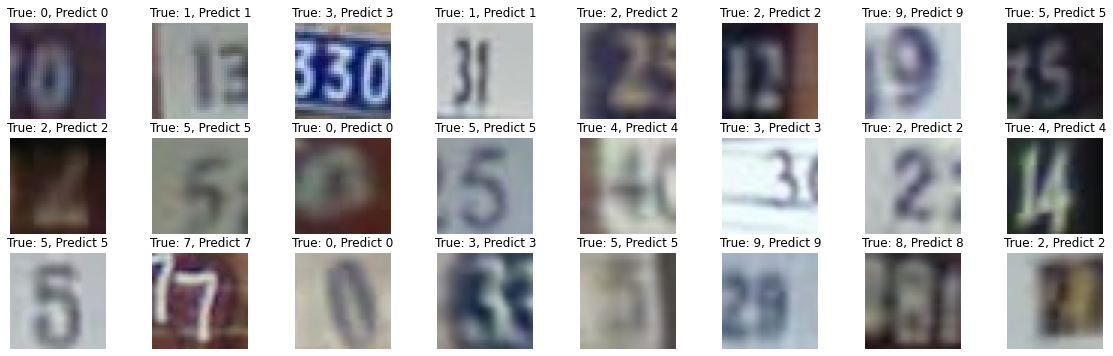

In [8]:
figure = plt.figure(figsize=(20, 6))
cols, rows = 8, 3

origin_train_data = dset.SVHN('./data/', split='test')
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(origin_train_data), size=(1,)).item()
    img, label = origin_train_data[sample_idx]

    transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])

    img_gpu = transform(img).to(device)

    y_probs = load_model(torch.unsqueeze(img_gpu, 0))
    y_hat = torch.argmax(y_probs, 1)

    figure.add_subplot(rows, cols, i)
    plt.title(f"True: {label}, Predict {int(y_hat)}")
    plt.axis("off")
    plt.imshow(img)
plt.show()